# Prediction of the isotopic inventory in a nuclear reactor core

*Benjamin Dechenaux, Jean-Baptiste Clavel, Cécilia Damon (IRSN)*

## Introduction 

Matter contained inside a nuclear reactor undergoes irradiation that causes successive cascades of nuclear reactions, modifying its atomic composition. Knowledge of this time evolving composition is an important parameter used to model the behavior of a nuclear reactor but is also a crucial input for safety studies associated with its operation and is a key input for the mitigation of severe accident for it constitute, for instance the source term of the release of radioactive isotopes in the environment. 

The modelling of the change in the atomic composition of irradiated materials over time is usually achieved using time expensive Monte Carlo simulation of the system being studied. Although precise, this calculation scheme has been found inadapted in crisis (i.e. accidental) situations, where faster calculation schemes have to be developped. 

This project aims at constructing a surrogate model capable at predicting the time changing nuclear inventory of a typical reactor of the French fleet. 

## Requirements for running the notebook 

To properly run the notebook, the following Python modules must be imported :

In [57]:
# Required for running the notebook 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns 
import pickle
import string


# sklearn dependences are used to build a baseline model 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Keras dependences used to established an example of Neural Network
from keras import models
from keras import layers
from keras.optimizers import Adagrad


%matplotlib inline

## Description of the data 

The atomic composition of the material subjected to irradiation usually involves thousands of isotopes. However, most of them have short lifetimes (characteristic decay time) and are not of critical interest for the safety of the facility or the mitigation of a reactor accident. 

In this project, we propose to track the temporal evolution of __26 isotopes__ that have a significant impact on the reactor behaviour or are isotopes whose composition is a key input for the study of the mitigation of an accident (they might be isotopes that are usually found to be released in the environment in accidental scenario, or are important for safety reasons in general). 

For non-proliferation reasons, the isotopes were renamed and each of them are identified by a unique letter of the alphabet (e.g. the first isotope whose composition we would like to track is named "A").   

So we'll be interested in the evolution of the content in isotopes "A", "B", ..., "Z" inside a reactor with time. The isotope content at each time is expressed in some kind of density unity ( ~ number of atoms per cubic cm).  

### Modelling the irradiation in a nuclear reactor

To model the irradiation conditions of the nuclear material, we suppose a simplified scheme for the temporal evolution.

Matter is put inside the reactor for a grand total of __1825 days__ (i.e. 5 years). 

This total period is subdivided into 5 different irradiation __cycles__ where each cycle correspond to a 300 days period with a certain configuration of the reactor (its operating power), charaterized by a single parameter *pi* (with i running from 1 -> 5).  

Between 2 cycles, a period of 65 days was added and correspond to say, a maintenance period for the reactor, where the fuel is not irradiated (which note, doesn't mean the isotopes don't evolve). During these intercycle period, we don't track the evolution of the isotopes content.

To summarize, the nuclear fuel is put inside of a reactor for a total of 1825 days with the following history :

* The fuel is irradiated for 300 days (from T = 0 to T = 300) with parameter *p1*
* The fuel is put to rest for 65 days
* The fuel is irradiated for 300 days (from T = 365 to T = 665) with parameter *p2*
* The fuel is put to rest for 65 days
* The fuel is irradiated for 300 days (from T = 730 to T = 1030) with parameter *p3*
* The fuel is put to rest for 65 days
* The fuel is irradiated for 300 days (from T = 1095 to T = 1395) with parameter *p4*
* The fuel is put to rest for 65 days
* The fuel is irradiated for 300 days (from T = 1460 to T = 1760) with parameter *p5*
* The fuel is put to rest for 65 days


For the sake of the exercise, the composition of each isotope will be tracked on a __20 days__ time interval basis, except for the periods where the fuel is put to rest, where the interval is 65 days (i.e. the evolution of fuel composition is not being tracked, which doesn't mean it doesn't evolve...) . 


So in the end, for a given set of input data (which consist of the inital composition of isotopes A -> H and the 5 parameters p1,...,p5), the result is a time series of length 81 (initial composition + 80 timesteps).


### Description of the available data

The database we built is composed of a total of __1120__ different reactor histories (i.e. time series), that we generated varying the initial conditions (i.e. the input parameters, see below) of the system and performing a detailled simulation of the reactor evolution in each case.  

For each of the 1120 simulations, we kept track of the composition of the 26 isotopes we are interested in. These are the output data of the database (see below). 


#### Input data 

The input data is composed of the initial composition of the matter before irradiation and the 5 parameters p1, .. p5 that specify the global operating conditions of the reactor for each irradiation cycle.

**This initial composition of the matter is only composed of isotopes __A to H__ ** (all the other are always equal to zero at the initial time T=0).

For each of the generated data point, the initial conditions (which is the input for any surrogate model) is composed of those 13 paramaters :

* Initial composition in terms of isotopes A --> H (8 parameters)
* Operating conditions of the reactor p1, ... , p5 (5 parameters)

For each of the 1120 differents simulations that were done, a unique set of values was picked in this initial input space using the latin hypercube method.   

#### Output data 

For each point in the input space, a simulation of the time evolving composition of matter was performed. The result of a simulation is a time series of length 81 (initial composition + 80 timesteps) for each isotope (form A to Z. Note that isotopes I -> Z always have zero composition at T=0). 

Those times series are stored in CSV output files that can be found under the _data/train_ and _data/test_ folders.

__Remark__

To ease the manipulation of the time series, the additional p1, ..., p5 input parameters were added to each of their corresponding timesteps (e.g. a time series named p1 which have the same value for each entry of the time series).


### Loading the data 

The 1120 simulations have been split into two *training* and *testing* datasets.

* The *training* dataset is composed of 920 simulations and are accessible in CSV format undert the __train__ folder
* The *testing* dataset is composed of 200 simulations and are accessible in CSV format undert the __test__ folder

To ease the reading of both the training and testing datasets, serialized *pandas* dataframes have been pre-prepared and can be loaded using *pickle*

In [3]:
dtrain = pickle.load( open("data/train_data_python3.pickle", "rb") )
dtest = pickle.load( open("data/test_data_python3.pickle", "rb") )

In these dataframes, data have been concatenated one on top of the other.


In [3]:
dtrain.head(5)

,times,A,B,C,D,E,F,G,H,I,...,V,W,X,Y,Z,p1,p2,p3,p4,p5
0,0.0,0.173951,4.219378,0.088625,2.014683,0.677343,0.079891,0.054258,0.164877,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.04842,0.029876,0.043997,0.03811,0.042866
1,20.0,0.172232,4.214907,0.088131,1.995882,0.678855,0.083688,0.054383,0.162316,0.000005,...,0.000038,0.000005,0.000160,0.000158,0.000362,0.04842,0.029876,0.043997,0.03811,0.042866
2,40.0,0.170516,4.210405,0.087780,1.977858,0.680277,0.087465,0.054536,0.159785,0.000031,...,0.000084,0.000022,0.000540,0.000316,0.000485,0.04842,0.029876,0.043997,0.03811,0.042866
3,60.0,0.168814,4.205899,0.087564,1.959920,0.681660,0.091179,0.054690,0.157300,0.000092,...,0.000132,0.000050,0.000999,0.000474,0.000526,0.04842,0.029876,0.043997,0.03811,0.042866
4,80.0,0.167123,4.201368,0.087465,1.942086,0.682998,0.094833,0.054855,0.154862,0.000190,...,0.000182,0.000088,0.001487,0.000631,0.000540,0.04842,0.029876,0.043997,0.03811,0.042866


In [5]:
dtrain

,times,A,B,C,D,E,F,G,H,I,...,V,W,X,Y,Z,p1,p2,p3,p4,p5
0,0.0,0.173951,4.219378,0.088625,2.014683,0.677343,0.079891,0.054258,0.164877,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.048420,0.029876,0.043997,0.038110,0.042866
1,20.0,0.172232,4.214907,0.088131,1.995882,0.678855,0.083688,0.054383,0.162316,0.000005,...,0.000038,0.000005,0.000160,0.000158,0.000362,0.048420,0.029876,0.043997,0.038110,0.042866
2,40.0,0.170516,4.210405,0.087780,1.977858,0.680277,0.087465,0.054536,0.159785,0.000031,...,0.000084,0.000022,0.000540,0.000316,0.000485,0.048420,0.029876,0.043997,0.038110,0.042866
3,60.0,0.168814,4.205899,0.087564,1.959920,0.681660,0.091179,0.054690,0.157300,0.000092,...,0.000132,0.000050,0.000999,0.000474,0.000526,0.048420,0.029876,0.043997,0.038110,0.042866
4,80.0,0.167123,4.201368,0.087465,1.942086,0.682998,0.094833,0.054855,0.154862,0.000190,...,0.000182,0.000088,0.001487,0.000631,0.000540,0.048420,0.029876,0.043997,0.038110,0.042866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,1700.0,0.150384,6.640561,0.175286,0.933834,0.592403,0.466433,0.310543,0.234692,0.011017,...,0.002702,0.010632,0.018255,0.005544,0.000441,0.006955,0.022862,0.029952,0.035575,0.038183
77,1720.0,0.149144,6.635300,0.176136,0.928589,0.591645,0.462749,0.311155,0.232837,0.011244,...,0.002769,0.011038,0.018604,0.005653,0.000441,0.006955,0.022862,0.029952,0.035575,0.038183
78,1740.0,0.147912,6.630026,0.176997,0.923353,0.590844,0.459130,0.311763,0.230971,0.011474,...,0.002834,0.011450,0.018953,0.005762,0.000441,0.006955,0.022862,0.029952,0.035575,0.038183
79,1760.0,0.146681,6.624729,0.177864,0.918136,0.590020,0.455569,0.312359,0.229107,0.011707,...,0.002899,0.011871,0.019300,0.005872,0.000441,0.006955,0.022862,0.029952,0.035575,0.038183


To separate from one file to the other, use the index of the dataframes or the "times" column.

The input data for instance is composed of the value of each T=0 entry in the datasets. To obtain those values, simply select every entry having T=0 in the train or test datasets : 

In [146]:
dtrain.loc[0].shape  # equivalent to dtrain.loc[dtrain["times"] == 0.]

(920, 32)

As said before, the train dataset regroup a total of 920 simulations that were performed varying the 13 input parameters listed above. Here the dataset is found to have 32 parameters at T=0, but only 13 are non zero, as can be seen using :  

In [147]:
dtrain.iloc[0]

times    0.000000
A        0.173951
B        4.219378
C        0.088625
D        2.014683
E        0.677343
F        0.079891
G        0.054258
H        0.164877
I        0.000000
J        0.000000
K        0.000000
L        0.000000
M        0.000000
N        0.000000
O        0.000000
P        0.000000
Q        0.000000
R        0.000000
S        0.000000
T        0.000000
U        0.000000
V        0.000000
W        0.000000
X        0.000000
Y        0.000000
Z        0.000000
p1       0.048420
p2       0.029876
p3       0.043997
p4       0.038110
p5       0.042866
Name: 0, dtype: float64

As adverstised, the initial compositions for isotopes "I" -> "Z" are zero, leaving only 13 input parameters. 
At T= 1825 days the (81th timestep), the composition has evolved :

In [148]:
dtrain.iloc[[0,80]]

,times,A,B,C,D,E,F,G,H,I,...,V,W,X,Y,Z,p1,p2,p3,p4,p5
0,0.0,0.173951,4.219378,0.088625,2.014683,0.677343,0.079891,0.054258,0.164877,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.04842,0.029876,0.043997,0.03811,0.042866
80,1825.0,0.085919,3.912349,0.119914,1.042389,0.682391,0.222099,0.076751,0.073000,0.01985,...,0.004407,0.014348,0.028545,0.009016,0.000014,0.04842,0.029876,0.043997,0.03811,0.042866


To get all of the timesteps, one can use the barbaric but efficient :

In [4]:
timesteps = sorted(list(set(dtrain["times"])))
print(timesteps)

[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0, 180.0, 200.0, 220.0, 240.0, 260.0, 280.0, 300.0, 365.0, 385.0, 405.0, 425.0, 445.0, 465.0, 485.0, 505.0, 525.0, 545.0, 565.0, 585.0, 605.0, 625.0, 645.0, 665.0, 730.0, 750.0, 770.0, 790.0, 810.0, 830.0, 850.0, 870.0, 890.0, 910.0, 930.0, 950.0, 970.0, 990.0, 1010.0, 1030.0, 1095.0, 1115.0, 1135.0, 1155.0, 1175.0, 1195.0, 1215.0, 1235.0, 1255.0, 1275.0, 1295.0, 1315.0, 1335.0, 1355.0, 1375.0, 1395.0, 1460.0, 1480.0, 1500.0, 1520.0, 1540.0, 1560.0, 1580.0, 1600.0, 1620.0, 1640.0, 1660.0, 1680.0, 1700.0, 1720.0, 1740.0, 1760.0, 1825.0]


## Remarks concerning the input space

The input space is made of the T=0 entry of each of the 1120 time series. 
It is composed of the initial composition of isotopes A to H and the 5 parameters p1 --> p5. 

Let us focus on the initial compositions of isotopes A --> H :

In [5]:
alphabet = list(string.ascii_uppercase) #  to ease the manipulation of the data

# The input compositions are isotopes A -> H  
input_compos= alphabet[0:8]

# The input paramters are composed of the input_compos + parameters p1 to p5 
input_params = input_compos + ["p1", "p2", "p3", "p4", "p5"]

# concatenate the T=0 entries for both the train and test datasets
input_space = pd.concat([dtrain.loc[0][input_params] , dtest.loc[0][input_params]  ]) 

In [6]:
input_space.shape

(1120, 13)

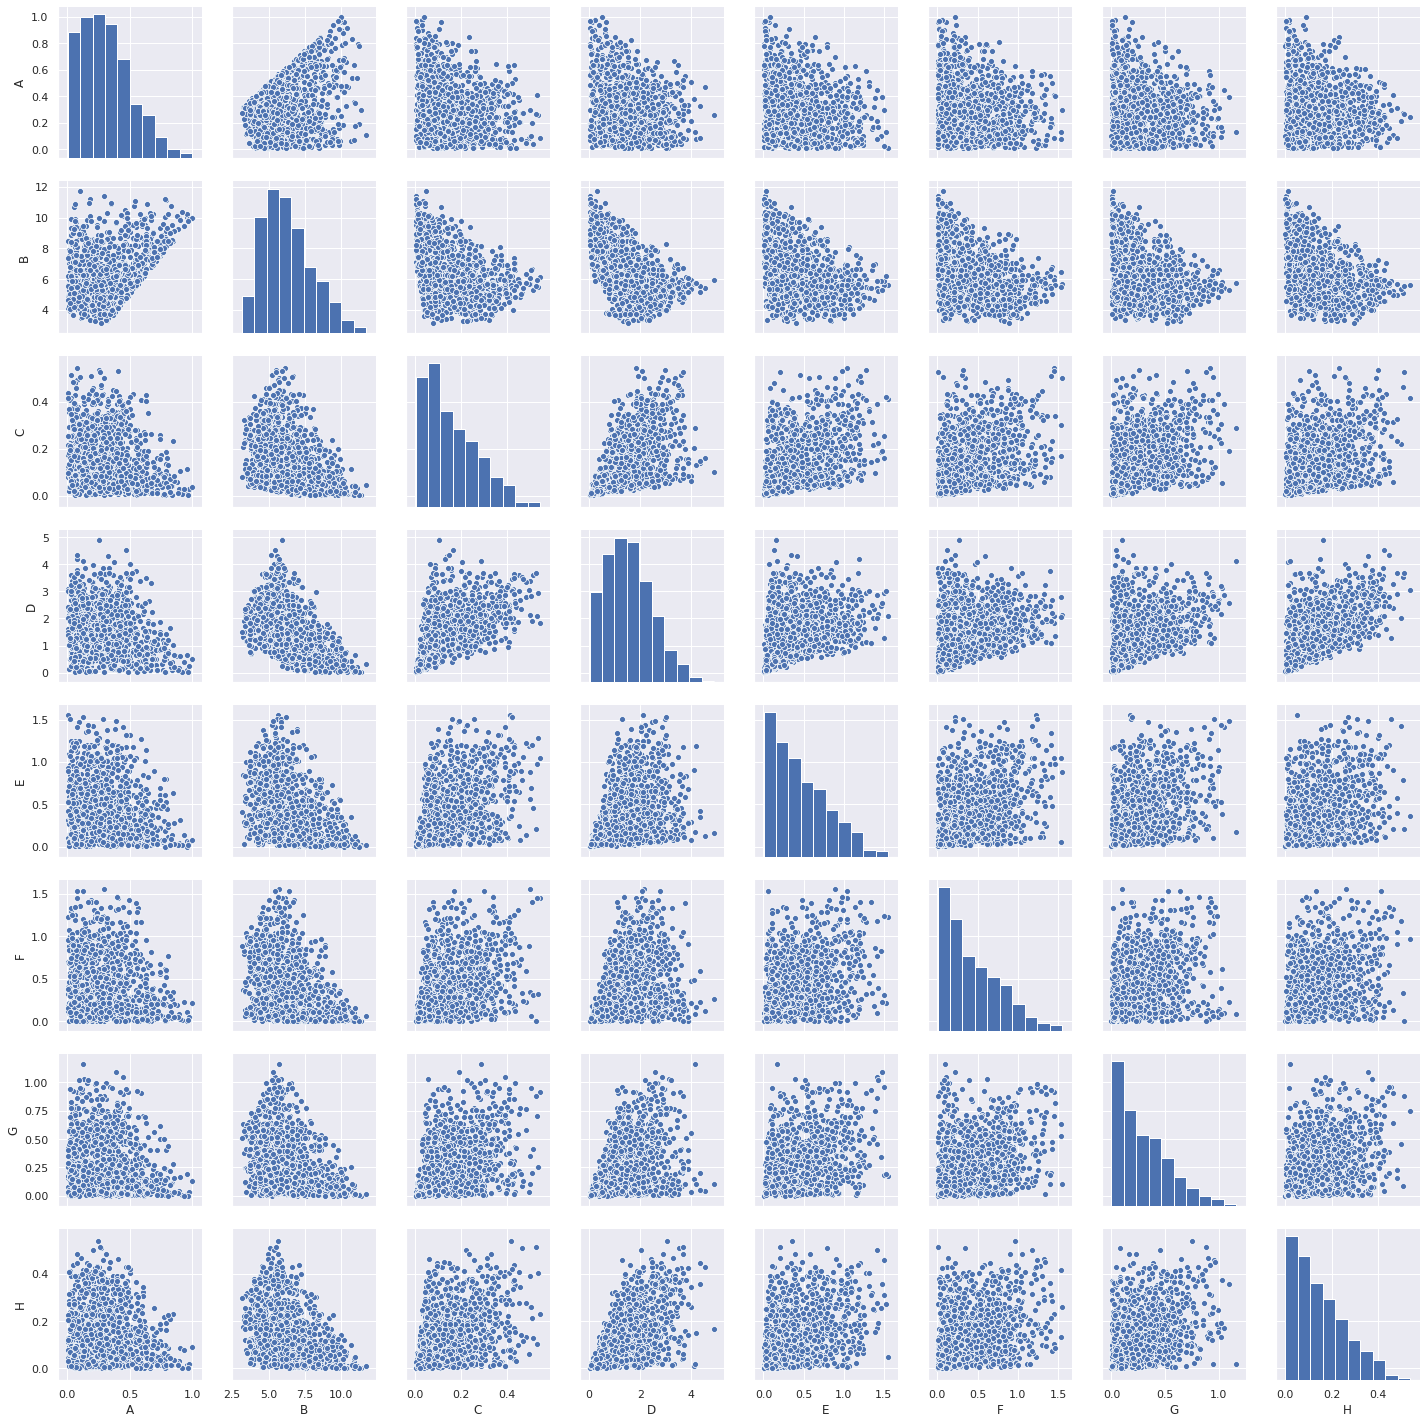

In [79]:
# Plot the initial compositions on a pairplot
sns.set_style("dark")
sns.set(rc={'figure.figsize':(16,20)})
sns.pairplot( input_space[input_compos] )
plt.show()

One can observe a non-uniform covering of the input space for the training dataset. and sometime clear cut in this input space sampling. 

This is because ratio of different quantities where used to determine boundaries in the sampling of the input parameter space. This was based on physical consideration and it was realised afterwards that it maybe wasn't the cleverest way to sample the data...  

## Normalization of the data

It is important to note that the composition data that make up the database are very heterogeneous. Indeed, the isotopes present in this database __have typical compositions that can present orders of magnitude of differences__. This can pose serious problems of normalization to succeed in learning the data at best. 

Let us for instance plot the distributions of the isotopes that makes up the input parameter space (i.e. isotopes A to H) at the initial T=0 and final T=1825 times : 

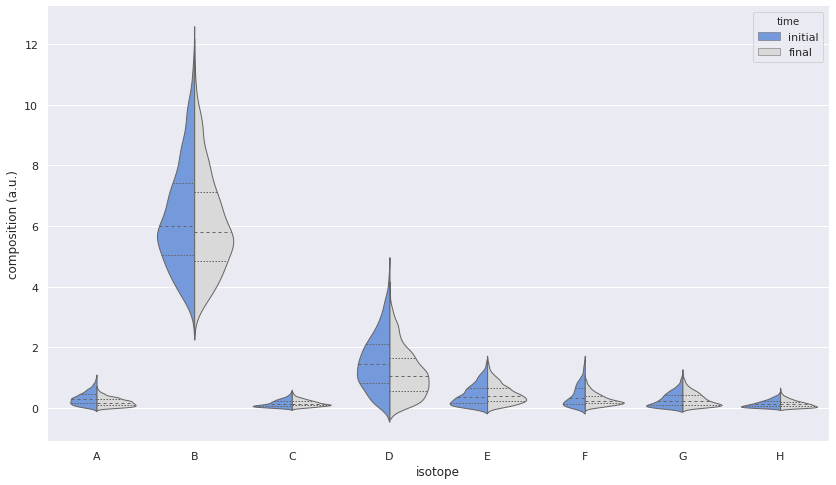

In [153]:
temp = pd.DataFrame()
for i in input_compos:
    temp=temp.append( pd.DataFrame( {"composition (a.u.)":dtrain[i].loc[0] , "isotope":[i for j in dtrain[i].loc[0]] , "time":["initial" for j in dtrain[i].loc[0]]} ) )
    temp=temp.append( pd.DataFrame( {"composition (a.u.)":dtrain[i].loc[80] , "isotope":[i for j in dtrain[i].loc[80]] , "time":["final" for j in dtrain[i].loc[80]]} ) )

## plot a violin plot for both the initial and final compositions of the input_compos  
sns.set(rc={'figure.figsize':(14,8)})
sns.violinplot(data=temp,x="isotope",y="composition (a.u.)",hue="time",split=True, inner="quartile", linewidth=1
               , palette={"initial":"cornflowerblue","final":".85"})
sns.despine(left=True)


As can be seen from the figure, most matter inside the reactor is made up of isotope B. 

The difficulty lies in the fact that we want, in the end, to have a precise __relative__ error on each individual isotope because it can happen that an isotope which is present in small quantities still has a non-negligible impact on the safety of the reactor and on the mitigation of an accident.

__So we can't just be good in the absolute overall composition of the matter : we need to be sufficiently precise for each individual isotope !__



The differences between the isotopes for the final compositions, adding all of the 26 isotopes, is even more flagrant :  

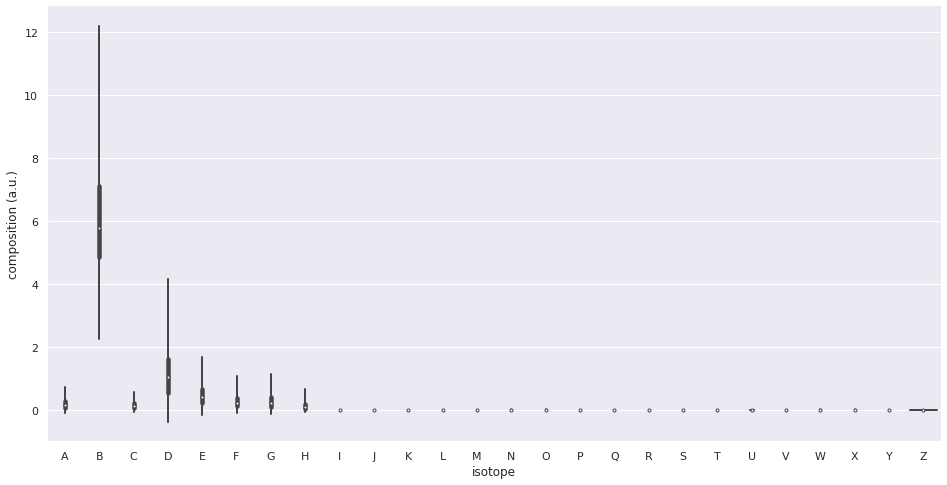

In [154]:
temp = pd.DataFrame()

for i in alphabet:
    temp=temp.append( pd.DataFrame( {"composition (a.u.)":dtrain[i].loc[80] , 
                                     "isotope":[i for j in dtrain[i].loc[80]] , 
                                     "time":["final" for j in dtrain[i].loc[80]]} ) )
  
sns.set(rc={'figure.figsize':(16,8)})
sns.violinplot(data=temp,x="isotope",y="composition (a.u.)", inner="box")
sns.despine(left=True)

There, we want to be sufficiently precise on each individual isotopes, even if there exist ~ up to 5 orders of magnitudes between some isotopes ! 

In [155]:
dtrain.B.max(), dtrain.Z.max()

(11.71932, 0.0006211064)

__To achieve good overall performances for this challenge, it is believed that the first key is to find a clever way to  normalize the input and output data.__

In this notebook, we will simply use the most straightforward normalization possible : we will divide each composition by the maximum found for each isotope :

In [6]:
max_train_data = dtrain.max()
dtrain_norm = dtrain/max_train_data

# perform the exact same operation on the test data 
dtest_norm = dtest/max_train_data

It makes things a bit better 

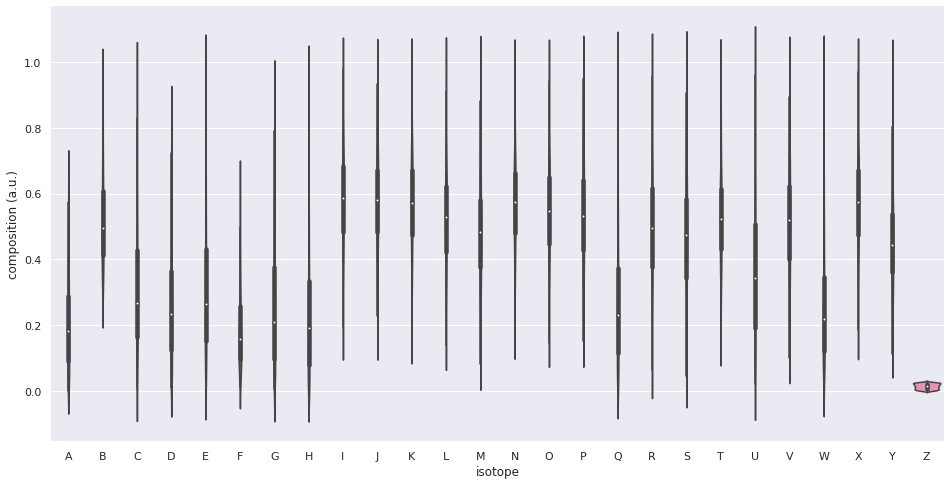

In [12]:
temp = pd.DataFrame()

for i in alphabet:
    temp=temp.append( pd.DataFrame( {"composition (a.u.)":dtrain_norm[i].loc[80] , 
                                     "isotope":[i for j in dtrain_norm[i].loc[80]] , 
                                     "time":["final" for j in dtrain_norm[i].loc[80]]} ) )
  
sns.set_style("dark")
sns.set(rc={'figure.figsize':(16,8)})
sns.violinplot(data=temp,x="isotope",y="composition (a.u.)", inner="box")
sns.despine(left=True)

It partially solves the problem, except for isotope Z which remains small as compared to the others...

## A simple baseline algorithm  

To benchmark the performances of a machine learning algorithm, we first try to build a simple baseline method.

Our goal is to predict the composition of matter inside the reactor **at any given time** by just using its initial composition (isotopes A --> H) and the parameters p1, ..., p5.

The baseline algorithm presented here simply performs a linear regression for each and every time step and for each isotope. 

Let us first reshape the data into a form that will be more usefull for the rest of this notebook 

In [7]:
train_data = dtrain_norm[alphabet].add_prefix('Y_')
train_data["times"] = dtrain_norm["times"]
train_data = train_data[ train_data["times"] > 0.]


temp = pd.DataFrame(np.repeat(dtrain_norm.loc[0][input_params].values, 80, axis=0), columns=input_params).reset_index(drop = True)
train_data = pd.concat([temp, train_data.reset_index(drop=True)], axis = 1)
display(train_data)

,A,B,C,D,E,F,G,H,p1,p2,...,Y_R,Y_S,Y_T,Y_U,Y_V,Y_W,Y_X,Y_Y,Y_Z,times
0,0.173969,0.360036,0.163230,0.446271,0.435704,0.051553,0.046750,0.257384,0.968901,0.600120,...,0.001006,0.023907,0.014016,0.000437,0.007372,0.000113,0.004920,0.011614,0.583623,0.010959
1,0.173969,0.360036,0.163230,0.446271,0.435704,0.051553,0.046750,0.257384,0.968901,0.600120,...,0.004260,0.048828,0.028339,0.001654,0.016239,0.000454,0.016625,0.023202,0.780646,0.021918
2,0.173969,0.360036,0.163230,0.446271,0.435704,0.051553,0.046750,0.257384,0.968901,0.600120,...,0.009417,0.072550,0.042912,0.003518,0.025447,0.001022,0.030789,0.034757,0.847143,0.032877
3,0.173969,0.360036,0.163230,0.446271,0.435704,0.051553,0.046750,0.257384,0.968901,0.600120,...,0.016173,0.095158,0.057661,0.005916,0.035010,0.001810,0.045801,0.046279,0.869604,0.043836
4,0.173969,0.360036,0.163230,0.446271,0.435704,0.051553,0.046750,0.257384,0.968901,0.600120,...,0.024234,0.116714,0.072580,0.008752,0.044900,0.002816,0.061083,0.057766,0.877192,0.054795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73595,0.216568,0.586937,0.249847,0.267245,0.397406,0.498443,0.230448,0.383898,0.139166,0.459242,...,0.493865,0.537330,0.572851,0.263394,0.519397,0.219291,0.562456,0.406605,0.709909,0.931507
73596,0.216568,0.586937,0.249847,0.267245,0.397406,0.498443,0.230448,0.383898,0.139166,0.459242,...,0.505905,0.541359,0.582078,0.266031,0.532221,0.227657,0.573223,0.414635,0.709830,0.942466
73597,0.216568,0.586937,0.249847,0.267245,0.397406,0.498443,0.230448,0.383898,0.139166,0.459242,...,0.518015,0.545169,0.591507,0.268760,0.544809,0.236167,0.583954,0.422652,0.709737,0.953425
73598,0.216568,0.586937,0.249847,0.267245,0.397406,0.498443,0.230448,0.383898,0.139166,0.459242,...,0.530126,0.548888,0.601001,0.271674,0.557177,0.244848,0.594652,0.430658,0.709657,0.964384


In [8]:
test_data = dtest_norm[alphabet].add_prefix('Y_')
test_data["times"] = dtest_norm["times"]
test_data = test_data[ test_data["times"] > 0.]

temp = pd.DataFrame(np.repeat(dtest_norm.loc[0][input_params].values, 80, axis=0), columns=input_params).reset_index(drop = True)
test_data = pd.concat([temp, test_data.reset_index(drop=True)], axis = 1)
display(test_data)

,A,B,C,D,E,F,G,H,p1,p2,...,Y_R,Y_S,Y_T,Y_U,Y_V,Y_W,Y_X,Y_Y,Y_Z,times
0,0.061299,0.707455,0.367089,0.24644,0.452398,0.278265,0.024499,0.363038,0.755038,0.549602,...,0.000785,0.019460,0.011579,0.000357,0.005908,0.000047,0.003756,0.008062,0.461040,0.010959
1,0.061299,0.707455,0.367089,0.24644,0.452398,0.278265,0.024499,0.363038,0.755038,0.549602,...,0.003339,0.039893,0.023350,0.001357,0.013002,0.000195,0.012695,0.016113,0.616583,0.021918
2,0.061299,0.707455,0.367089,0.24644,0.452398,0.278265,0.024499,0.363038,0.755038,0.549602,...,0.007411,0.059481,0.035266,0.002906,0.020365,0.000447,0.023519,0.024153,0.669015,0.032877
3,0.061299,0.707455,0.367089,0.24644,0.452398,0.278265,0.024499,0.363038,0.755038,0.549602,...,0.012746,0.078266,0.047332,0.004919,0.027970,0.000801,0.034997,0.032179,0.686657,0.043836
4,0.061299,0.707455,0.367089,0.24644,0.452398,0.278265,0.024499,0.363038,0.755038,0.549602,...,0.019128,0.096283,0.059506,0.007321,0.035834,0.001263,0.046688,0.040192,0.692536,0.054795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0.671531,0.863472,0.099173,0.06329,0.168123,0.133083,0.076684,0.063998,0.986731,0.590391,...,0.809016,0.256957,0.510268,0.150747,0.710275,0.504558,0.761935,0.816187,0.350558,0.931507
15996,0.671531,0.863472,0.099173,0.06329,0.168123,0.133083,0.076684,0.063998,0.986731,0.590391,...,0.814221,0.257052,0.511905,0.152365,0.714212,0.509402,0.765915,0.820591,0.350521,0.942466
15997,0.671531,0.863472,0.099173,0.06329,0.168123,0.133083,0.076684,0.063998,0.986731,0.590391,...,0.819490,0.257132,0.513362,0.153848,0.718336,0.514272,0.769870,0.824982,0.350444,0.953425
15998,0.671531,0.863472,0.099173,0.06329,0.168123,0.133083,0.076684,0.063998,0.986731,0.590391,...,0.824753,0.257106,0.514917,0.155368,0.722247,0.519073,0.773806,0.829356,0.350367,0.964384


Now for each isotope and each timestep, we will try to construct a linear regression that best fit the data  

In [58]:
res_target = pd.DataFrame()

for abc in alphabet:
    output = "Y_"+abc
    
    train_target = train_data.groupby(input_params)[output].apply(list).apply(pd.Series)\
                .rename(columns=lambda x: abc+str(x+1)).reset_index()
    test_target = test_data.groupby(input_params)[output].apply(list).apply(pd.Series)\
                .rename(columns=lambda x: abc+str(x+1)).reset_index()
    y_test = []
    y_pred = []
    for i in range(80):
        ytimes = abc+str(i+1)

        X_train = train_target[input_params]
        y_train = train_target[ytimes]
        X_test = test_target[input_params]
        y_test.append( test_target[ytimes].to_list())

        reg_ols = LinearRegression()
        y_pred.append( reg_ols.fit(X_train, y_train).predict(X_test) ) 
        #r2_score_ols = r2_score(y_test, y_pred_ols)
        #mae_score_ols = mean_absolute_error(y_test, y_pred_ols)
        
    res_target["tar_%s"%(abc)] = np.array(y_test).flatten()
    res_target["res_%s"%(abc)] = np.array(y_pred).flatten()
        
    res_target["mae_%s"%(abc)]  = np.fabs(res_target["tar_%s"%(abc)] - res_target["res_%s"%(abc)]) 
    res_target["mape_%s"%(abc)] = np.fabs(res_target["tar_%s"%(abc)] - res_target["res_%s"%(abc)])/res_target["tar_%s"%(abc)] 

        


    Note : what's really interesting is the relative prediction error, i.e. the error relative to the true composition. In this sense, the Mean Absolute Percentage Error (MAPE) is believed to be a better indicator to judge the overall performance of the regression.


Let's look at the results for two very different isotopes. Isotope B is initially present in large quantity in the system ( B at T=0 >> 0). So it is expected that the prediction error at intial times be small

Let's compare the results for B with those for isotope R which has a zero composition initially 

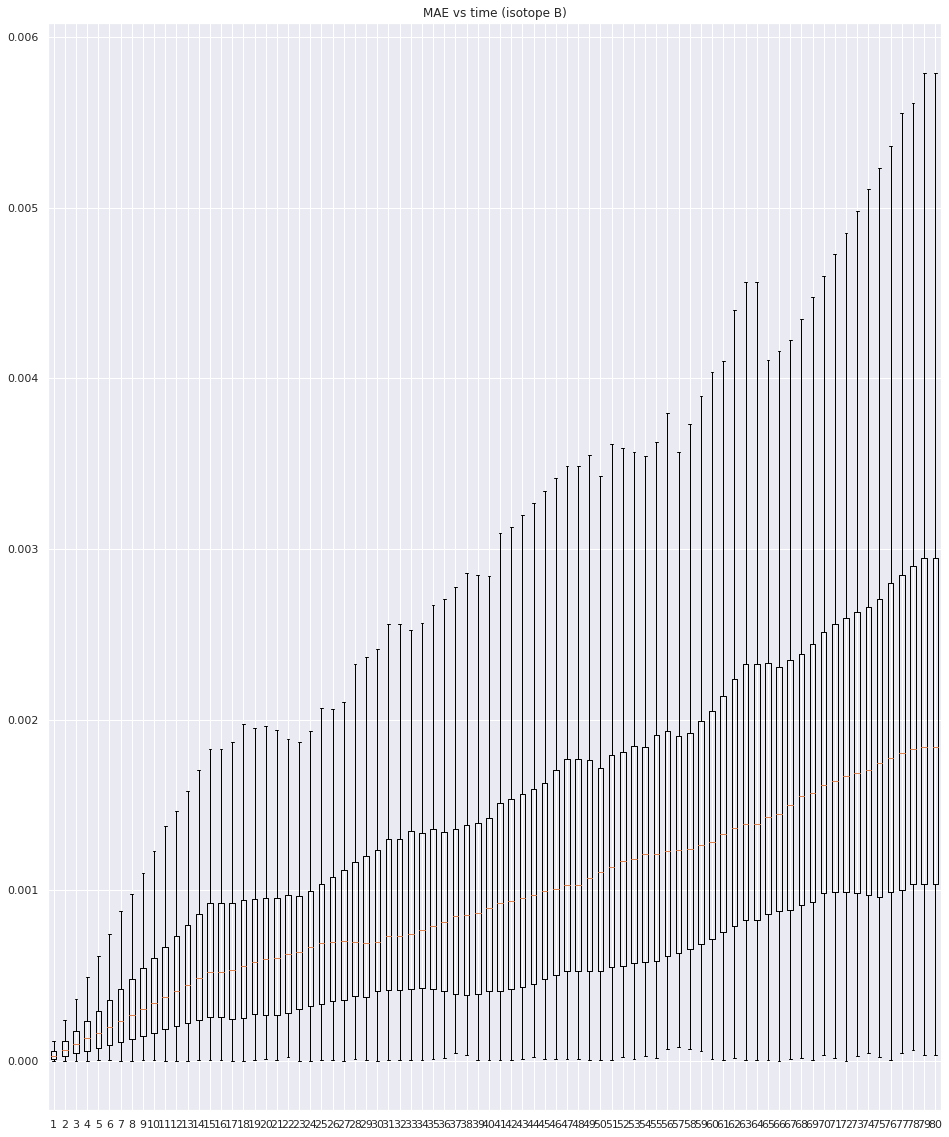

In [80]:
dist =  np.array([res_target["mae_B"].iloc[i*200:(i+1)*200] for i in range(80) ])
plt.boxplot(dist.T,showfliers=False)
plt.title("MAE vs time (isotope B)")
plt.show()

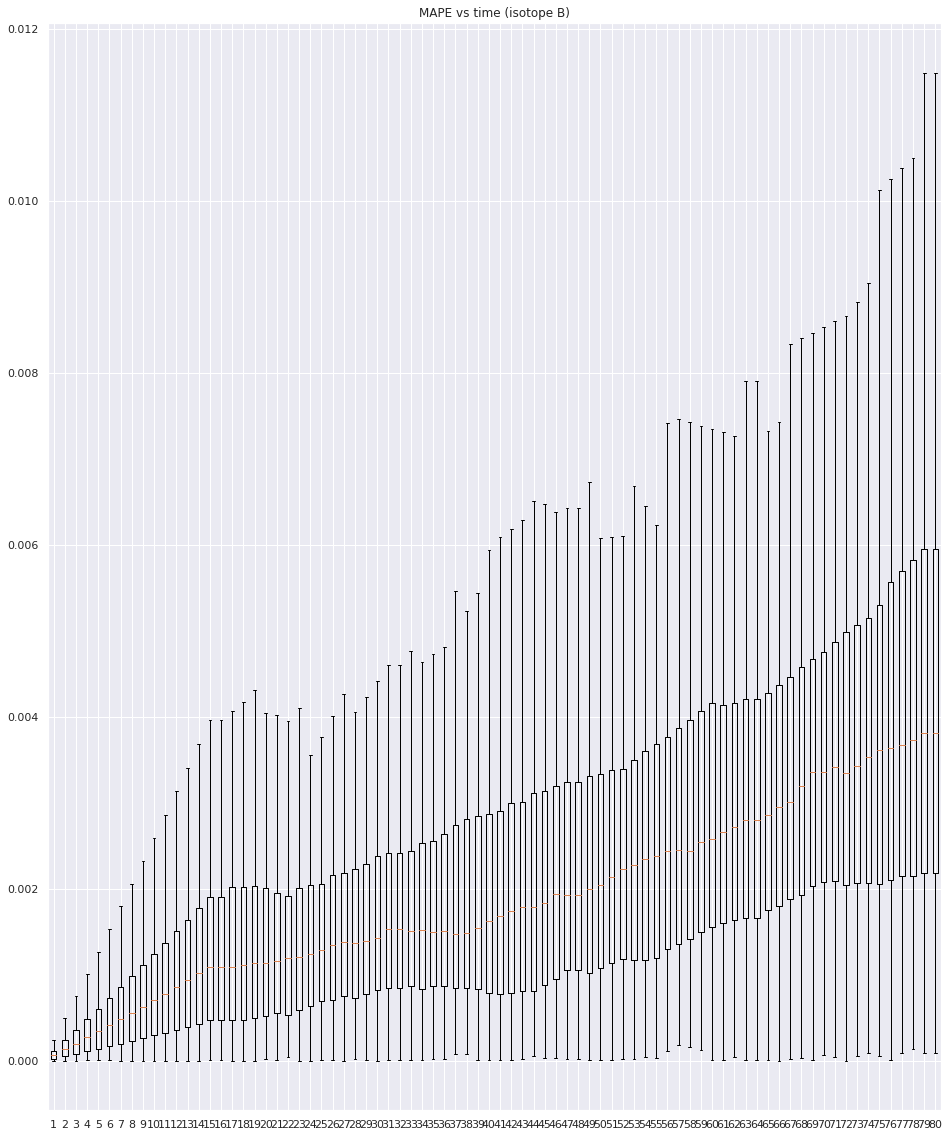

In [81]:
dist =  np.array([res_target["mape_B"].iloc[i*200:(i+1)*200] for i in range(80) ])
plt.boxplot(dist.T,showfliers=False)

plt.title("MAPE vs time (isotope B)")
plt.show()

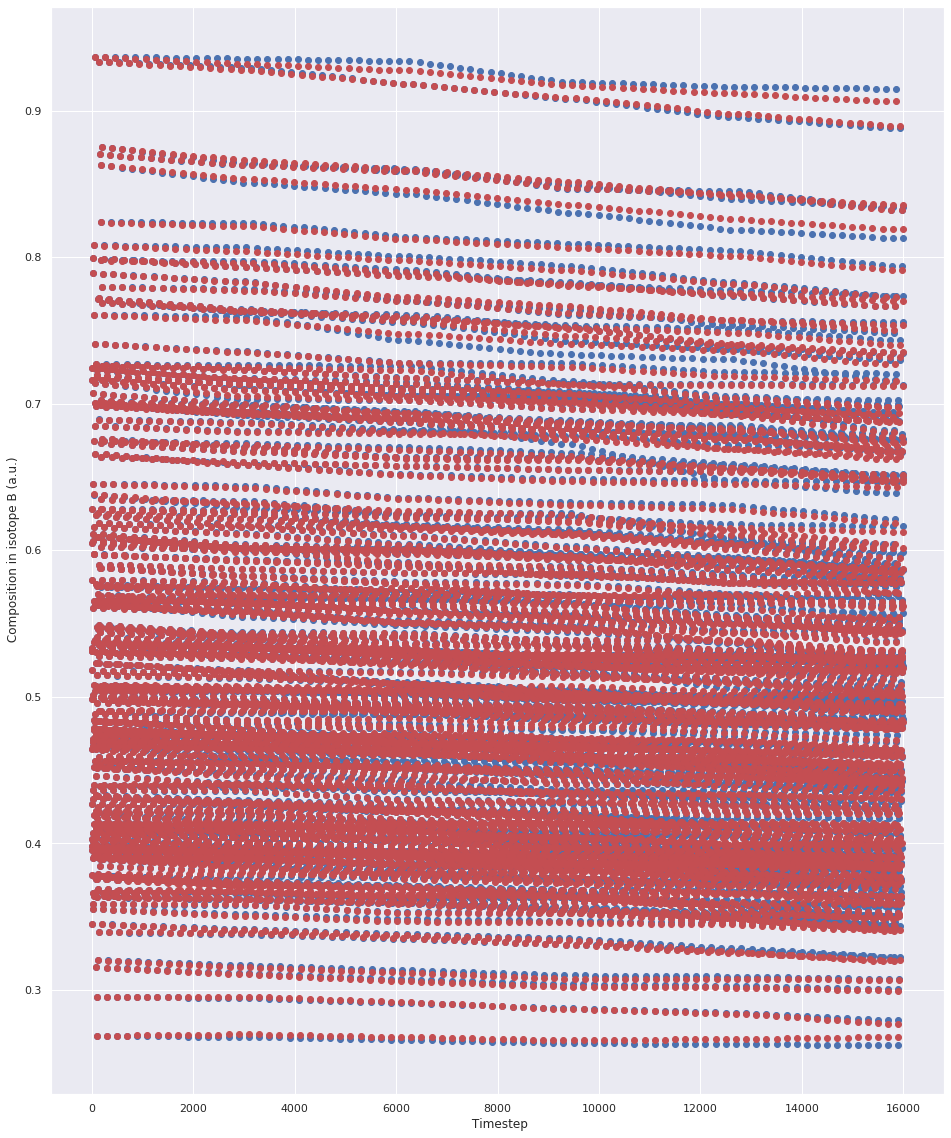

In [82]:
plt.plot( range( res_target.tar_B.shape[0] )  , res_target.tar_B ,"bo"  )  
plt.plot( range( res_target.res_B.shape[0] )  , res_target.res_B ,"ro"  )  

plt.xlabel(" Timestep")
plt.ylabel(" Composition in isotope B (a.u.)")
plt.show()


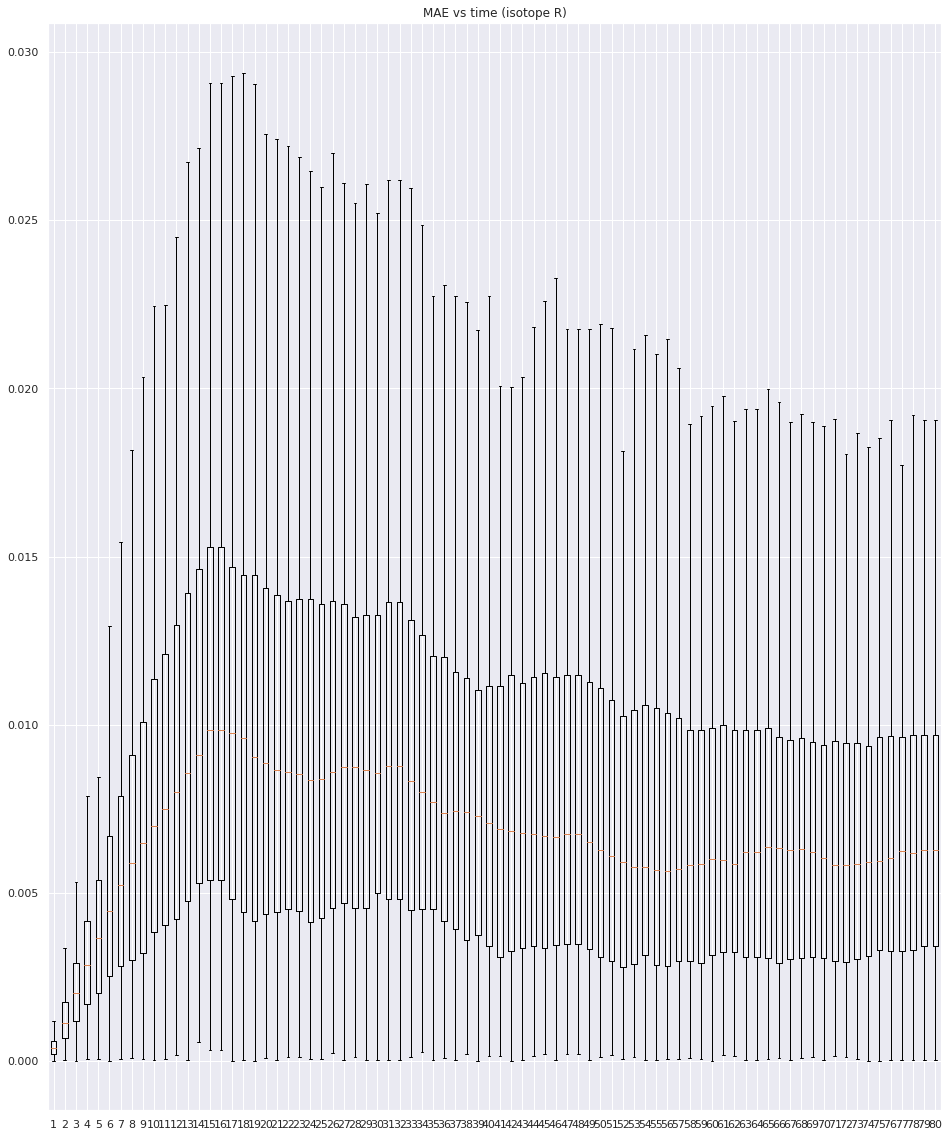

In [83]:
dist =  np.array([res_target["mae_R"].iloc[i*200:(i+1)*200] for i in range(80) ])
plt.boxplot(dist.T,showfliers=False)
plt.title("MAE vs time (isotope R)")
plt.show()

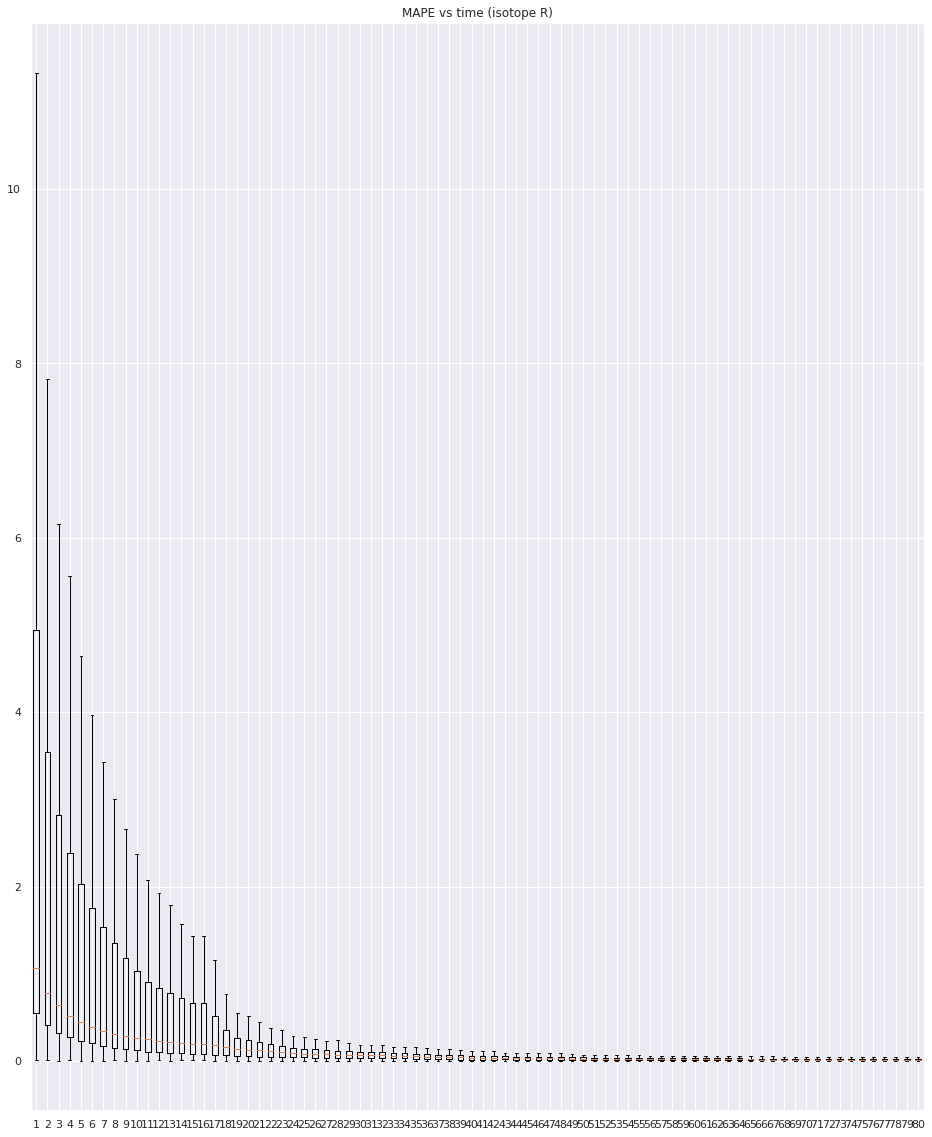

In [84]:
dist =  np.array([res_target["mape_R"].iloc[i*200:(i+1)*200] for i in range(80) ])
plt.boxplot(dist.T,showfliers=False)
plt.title("MAPE vs time (isotope R)")
plt.show()

The results for isotope R (in blue : true data,  in red : predicted data)

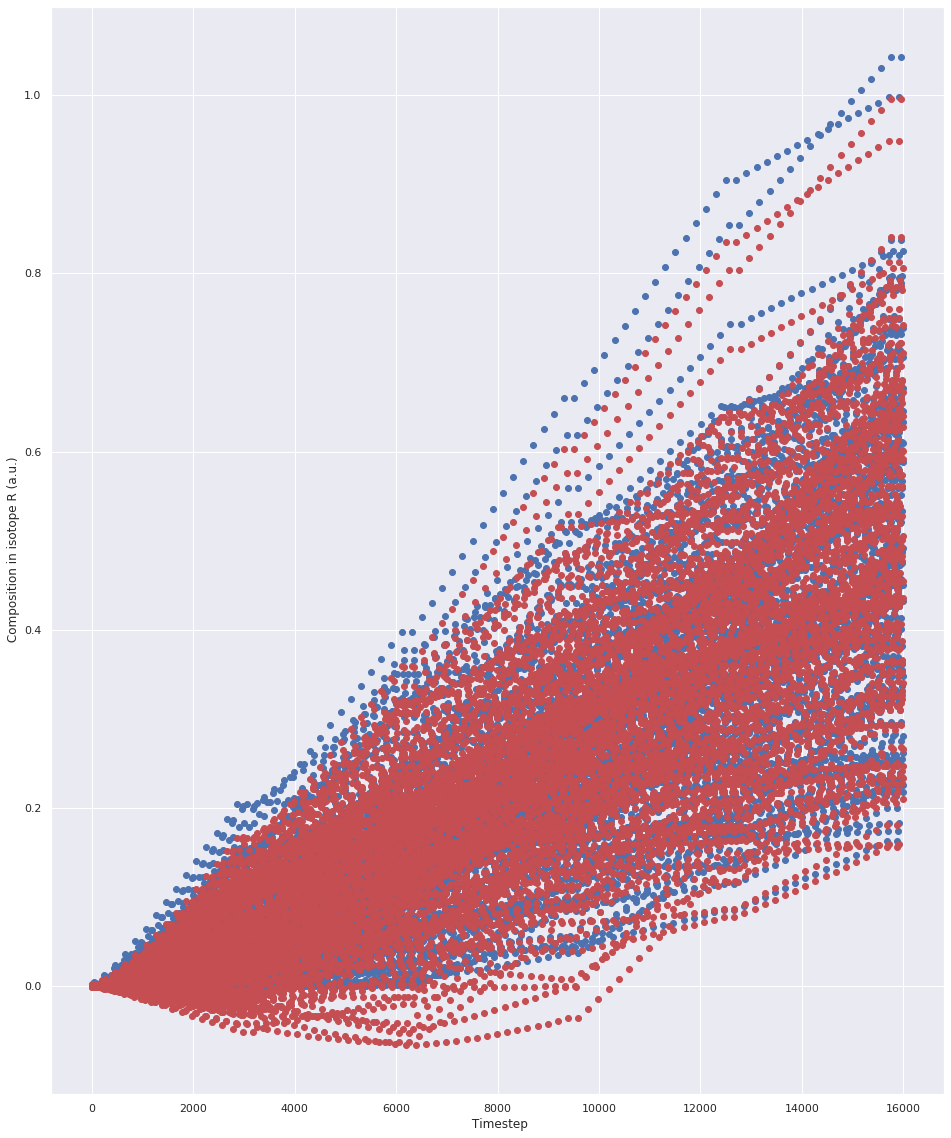

In [85]:
plt.plot( range( res_target.tar_R.shape[0] )  , res_target.tar_R ,"bo"  )  
plt.plot( range( res_target.res_R.shape[0] )  , res_target.res_R ,"ro"  )  

plt.xlabel(" Timestep")
plt.ylabel(" Composition in isotope R (a.u.)")
plt.show()



Now we try to build a unique indicator for each isotopes, summing over all timesteps :

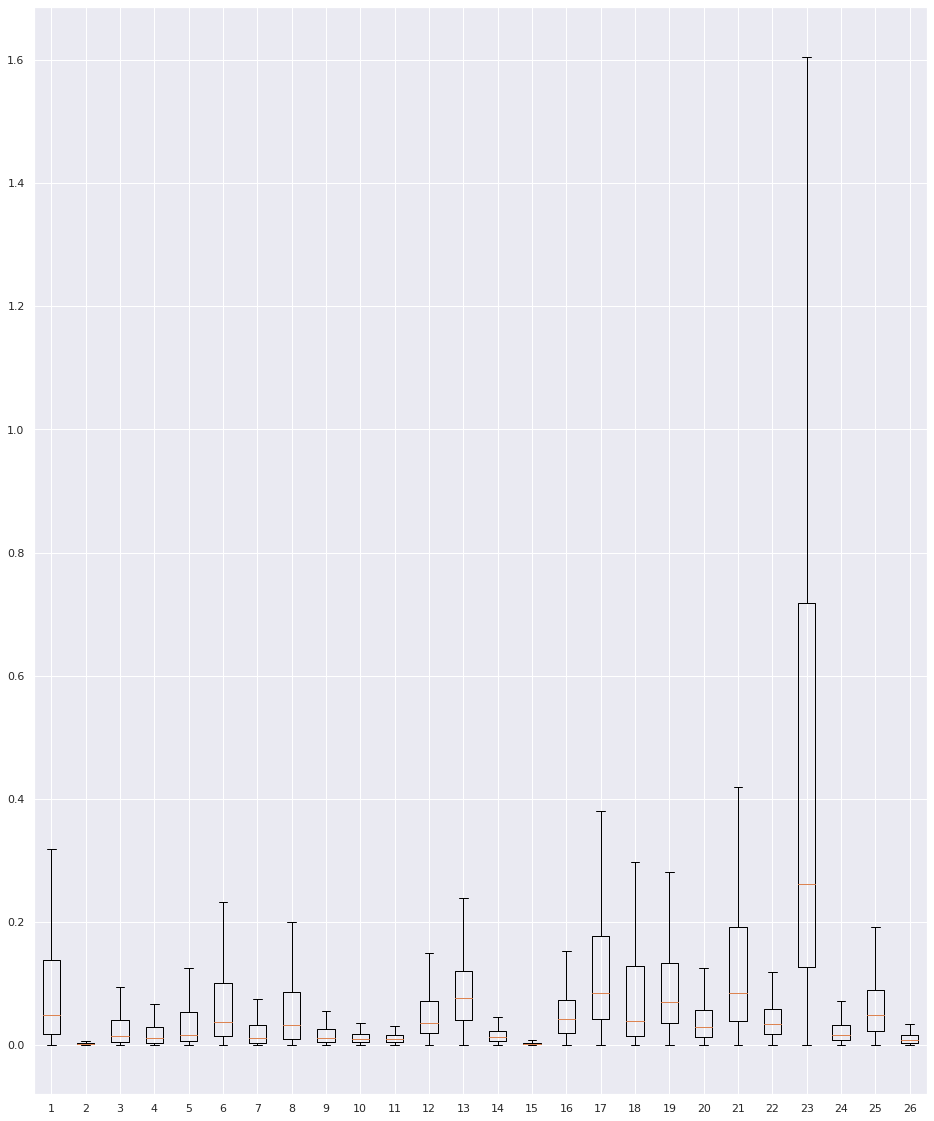

In [87]:
dist = np.array([res_target["mape_%s"%(abc)] for abc in alphabet] )

plt.boxplot(dist.T,showfliers=False)
plt.show()

In [104]:
mape_tot = dist.mean(axis=1)

print("Mean Accuracy (%)")
for i,abc in enumerate(alphabet):
    print("%s  %.2f"%(abc,np.fabs(100 - mape_tot[i]*100 )))

Mean Accuracy (%)
A  79.40
B  99.77
C  94.61
D  94.26
E  94.48
F  91.56
G  96.07
H  5.92
I  96.34
J  98.39
K  98.28
L  91.75
M  85.55
N  97.86
O  99.59
P  91.96
Q  54.37
R  551.73
S  82.89
T  94.37
U  38.72
V  92.32
W  642.71
X  96.49
Y  87.02
Z  97.14


A global, unique, estimator can be derived, summing the mape for each isotopes :

In [94]:
mape_tot.sum()

17.35332594013608

A machine learning algorithm must beat those numbers to pretend doing any decent job ! 

## A naive neural network attempt

We will use a standard neural network built from the keras library. 

To treat time, we choose simply to treat this parameter has an input variable that will be fed to the neural network.


Our goal is to predict the composition of matter inside the reactor **at any given time** by just using its initial composition (isotopes A --> H) and the parameters p1, ..., p5.

To makes thing a bit more simple, we'll use the transformed training and testing datasets. this will ease the use of a network with time is an input parameter.

Note : We use the shuffle function to mix the time-sorted datasets 

The training dataset looks like : 

In [134]:
train_data = dtrain_norm[alphabet].add_prefix('Y_')
train_data["times"] = dtrain_norm["times"]
train_data = train_data[ train_data["times"] > 0.]

temp = pd.DataFrame(np.repeat(dtrain_norm.loc[0][input_params].values, 80, axis=0), columns=input_params).reset_index(drop = True)
train_data = pd.concat([temp, train_data.reset_index(drop=True)], axis = 1)

train_data = shuffle(train_data, random_state=57)
train_data

,A,B,C,D,E,F,G,H,p1,p2,...,Y_R,Y_S,Y_T,Y_U,Y_V,Y_W,Y_X,Y_Y,Y_Z,times
65038,0.215735,0.342085,0.117592,0.360926,0.106020,0.287385,0.456477,0.123048,0.765523,0.368171,...,0.532031,0.481346,0.594910,0.358983,0.560296,0.384931,0.596421,0.426825,0.191491,0.964384
70211,0.045008,0.630348,0.138979,0.090456,0.064394,0.088199,0.062593,0.005928,0.726570,0.229312,...,0.293896,0.131685,0.301171,0.017509,0.309576,0.152880,0.260688,0.202140,0.835551,0.643836
52984,0.338341,0.463895,0.521140,0.187534,0.566894,0.483925,0.379128,0.230516,0.959677,0.429547,...,0.198416,0.352720,0.285076,0.122878,0.212952,0.073646,0.282491,0.212932,0.402392,0.298630
27912,0.339966,0.710961,0.124716,0.151071,0.137579,0.189399,0.217173,0.133705,0.522035,0.743420,...,0.593796,0.310303,0.499647,0.095339,0.592489,0.473481,0.579078,0.503626,0.725092,0.898630
45300,0.225719,0.547601,0.635470,0.522322,0.347247,0.797577,0.848637,0.290519,0.357749,0.666472,...,0.031043,0.225019,0.137463,0.072466,0.082698,0.010635,0.127922,0.092155,0.611697,0.254795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31784,0.424129,0.522400,0.717321,0.376195,0.440030,0.671180,0.482487,0.436438,0.467628,0.426308,...,0.056738,0.262195,0.167170,0.105481,0.104872,0.014875,0.168592,0.125728,0.397117,0.298630
19064,0.007283,0.480976,0.759716,0.463687,1.000000,0.790619,0.151370,0.077651,0.919727,0.526934,...,0.127971,0.432559,0.305046,0.185880,0.197906,0.020182,0.277423,0.177789,0.481775,0.298630
35845,0.168157,0.588212,0.496728,0.560255,0.212773,0.336975,0.430032,0.143727,0.145136,0.630093,...,0.000571,0.024677,0.013158,0.002521,0.008239,0.000148,0.011770,0.010036,0.135393,0.065753
11990,0.132368,0.588655,0.095203,0.229172,0.225592,0.357678,0.368707,0.216414,0.100592,0.985846,...,0.550234,0.437004,0.560561,0.161021,0.575310,0.416521,0.555294,0.403303,0.764016,0.876712


And for the test dataset

In [133]:
test_data = dtest_norm[alphabet].add_prefix('Y_')
test_data["times"] = dtest_norm["times"]
test_data = test_data[ test_data["times"] > 0.]

temp = pd.DataFrame(np.repeat(dtest_norm.loc[0][input_params].values, 80, axis=0), columns=input_params).reset_index(drop = True)
test_data = pd.concat([temp, test_data.reset_index(drop=True)], axis = 1)

test_data = shuffle(test_data, random_state=57)
test_data

,A,B,C,D,E,F,G,H,p1,p2,...,Y_R,Y_S,Y_T,Y_U,Y_V,Y_W,Y_X,Y_Y,Y_Z,times
13678,0.101091,0.565322,0.925709,0.629494,0.444943,0.042849,0.814979,0.402769,0.140636,0.858761,...,0.453590,0.622086,0.588053,0.552944,0.510164,0.329651,0.599391,0.424545,0.361415,0.964384
11622,0.623200,0.673401,0.479298,0.571193,0.245700,0.081616,0.110693,0.143814,0.814258,0.524589,...,0.124262,0.323810,0.230783,0.107726,0.154918,0.024200,0.252909,0.218481,0.485047,0.276712
923,0.139273,0.508336,0.405438,0.462501,0.766785,0.677719,0.064330,0.131481,0.295461,0.307537,...,0.042635,0.233904,0.147811,0.201525,0.091483,0.003844,0.146931,0.093280,0.016897,0.531507
4884,0.094350,0.479431,0.557239,0.706505,0.337189,0.052896,0.879975,0.209582,0.969397,0.025114,...,0.014777,0.123457,0.072715,0.010108,0.044740,0.007295,0.060409,0.054454,0.868574,0.054795
6210,0.033544,0.533634,0.465635,0.403526,0.726080,0.225247,0.198087,0.290582,0.012631,0.050103,...,0.134917,0.311849,0.232267,0.117255,0.167662,0.036565,0.224597,0.152562,0.157405,0.632877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3151,0.268672,0.417535,0.602449,0.450674,0.468921,0.175045,0.391007,0.531049,0.014241,0.544359,...,0.048722,0.196599,0.124891,0.063837,0.082743,0.014549,0.135002,0.099666,0.014577,0.400000
12694,0.240873,0.413693,0.276995,0.356286,0.809729,0.783855,0.306778,0.290818,0.611259,0.667260,...,0.362112,0.630607,0.549702,0.400321,0.413135,0.109401,0.510573,0.351079,0.823824,0.676712
3077,0.364883,0.477123,0.270663,0.175179,0.272992,0.300775,0.021421,0.289029,0.542650,0.591610,...,0.293453,0.334206,0.341945,0.082982,0.287904,0.053196,0.340619,0.283727,0.880996,0.465753
11990,0.427967,0.439405,0.325614,0.470729,0.344762,0.133335,0.101990,0.401198,0.109839,0.576283,...,0.219217,0.392631,0.323245,0.265764,0.241364,0.048282,0.341793,0.270700,0.454404,0.876712


Build a basic neural network architecture ( 13 input parameters + time)

In [135]:
# Build simple MLP 

model = models.Sequential()
model.add( layers.Dense(100,activation='relu', input_shape= (train_data[input_params + ["times"]].shape[1],))  )
model.add( layers.Dense(100,activation='relu'))
model.add( layers.Dense(100,activation='relu'))
model.add( layers.Dense(100,activation='relu'))
model.add( layers.Dense(26) )

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 100)               1500      
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_15 (Dense)             (None, 26)                2626      
Total params: 34,426
Trainable params: 34,426
Non-trainable params: 0
_________________________________________________________________


To train the surrogate model, We used MAPE both for loss and validation. 
A more refined choice might be necessary ... 

In [136]:
model.compile( optimizer=Adagrad() , loss="mape", metrics=["mape"])  

history = model.fit( train_data[input_params + ["times"]] , train_data[["Y_"+i for i in alphabet]] , 
                    epochs=500, batch_size=20, validation_split=0.3,verbose=0) 


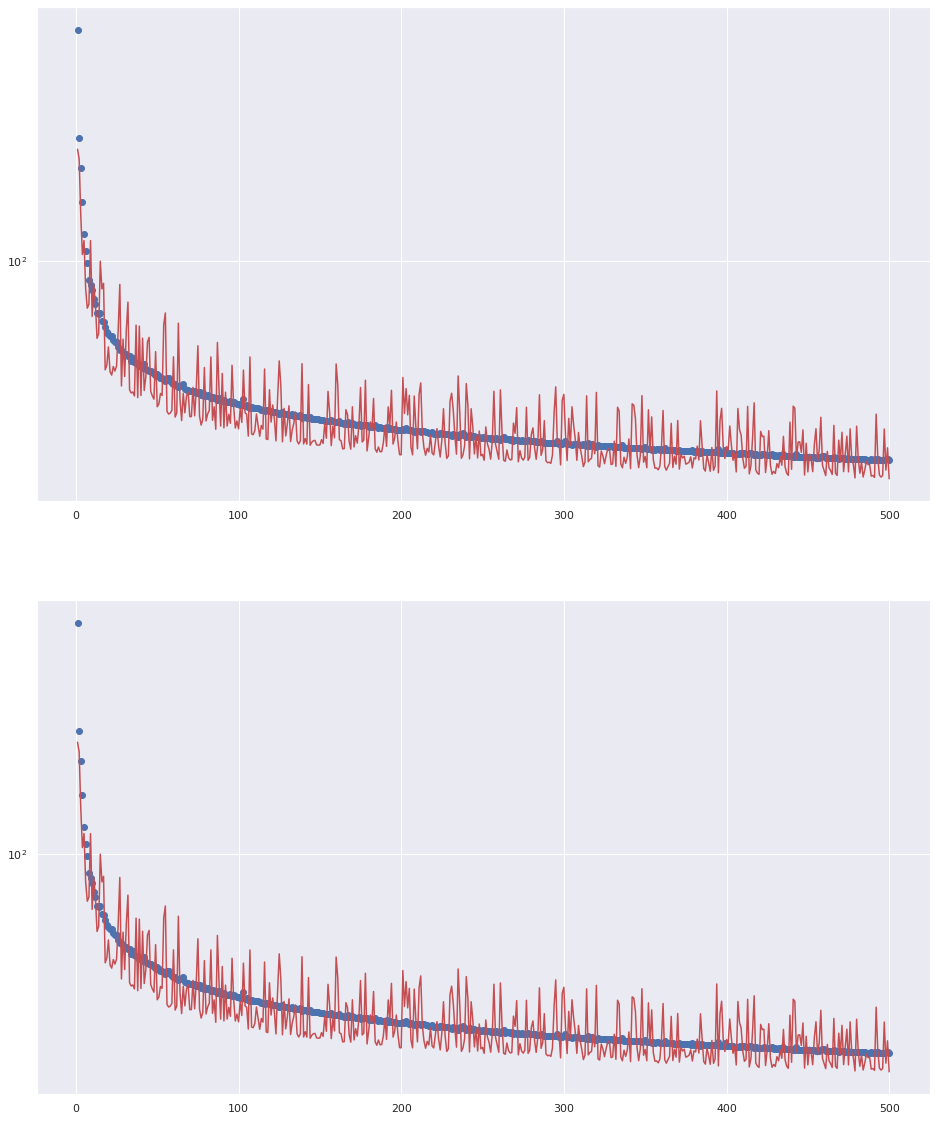

In [137]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1 , len(loss)+1)

plt.subplot( 2 , 1, 1 )
plt.plot(epochs , loss , "bo")
plt.plot(epochs , val_loss , "r")
plt.yscale("log")
plt.subplot( 2 , 1, 2 )
plt.plot(epochs , history.history["mean_absolute_percentage_error"] , "bo") # mean_absolute_percentage_error
plt.plot(epochs , history.history["val_mean_absolute_percentage_error"]  , "r")

plt.yscale("log")
plt.show()

In [138]:
# Use NN to predict the compos of test data 
res = model.predict( test_data[input_params + ["times"]]  )

for i,val in enumerate(alphabet):
    test_data["res_"+val] = res[:,i]

mlp_mape_tot = 0
print( "Mean accuracy (%) :")
print("name, MLP, Linear Fit")
for i,name in enumerate(alphabet):
    
    test_data["mape_"+name] = np.fabs(test_data["Y_"+name]-test_data["res_"+name])/test_data["Y_"+name]
    mlp_mape_tot += test_data["mape_"+name].mean()
    print(name, "   %.2f    %.2f"%(100-np.fabs(test_data["mape_"+name].mean()*100)  , np.fabs(100 - mape_tot[i]*100 )  ) )

Mean accuracy (%) :
name, MLP, Linear Fit
A    76.90    79.40
B    93.68    99.77
C    83.54    94.61
D    87.24    94.26
E    83.46    94.48
F    81.42    91.56
G    80.45    96.07
H    74.84    5.92
I    88.18    96.34
J    92.79    98.39
K    92.74    98.28
L    92.06    91.75
M    90.04    85.55
N    92.84    97.86
O    92.47    99.59
P    84.74    91.96
Q    90.75    54.37
R    78.30    551.73
S    92.49    82.89
T    92.39    94.37
U    83.11    38.72
V    91.22    92.32
W    27.69    642.71
X    92.36    96.49
Y    91.67    87.02
Z    6.05    97.14


Like before, we use each individual MAPE scores to build a global index for estimating the performance of the neural network : 

In [139]:
mlp_mape_tot

4.6659395045074

The linear fit performance was around 17 

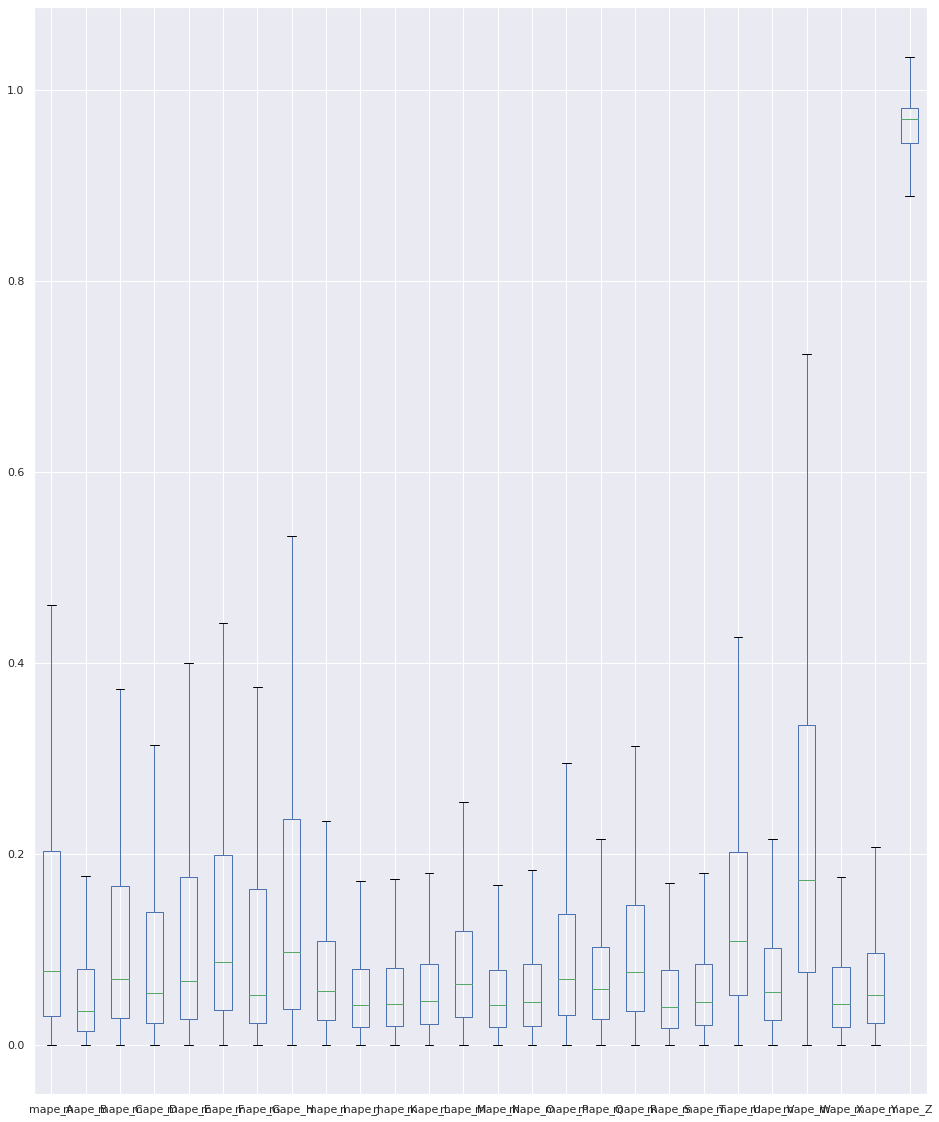

In [140]:
test_data[ ["mape_"+abc for abc in alphabet]  ].boxplot(showfliers=False)

 We might now want to investigate the problem in more depth :

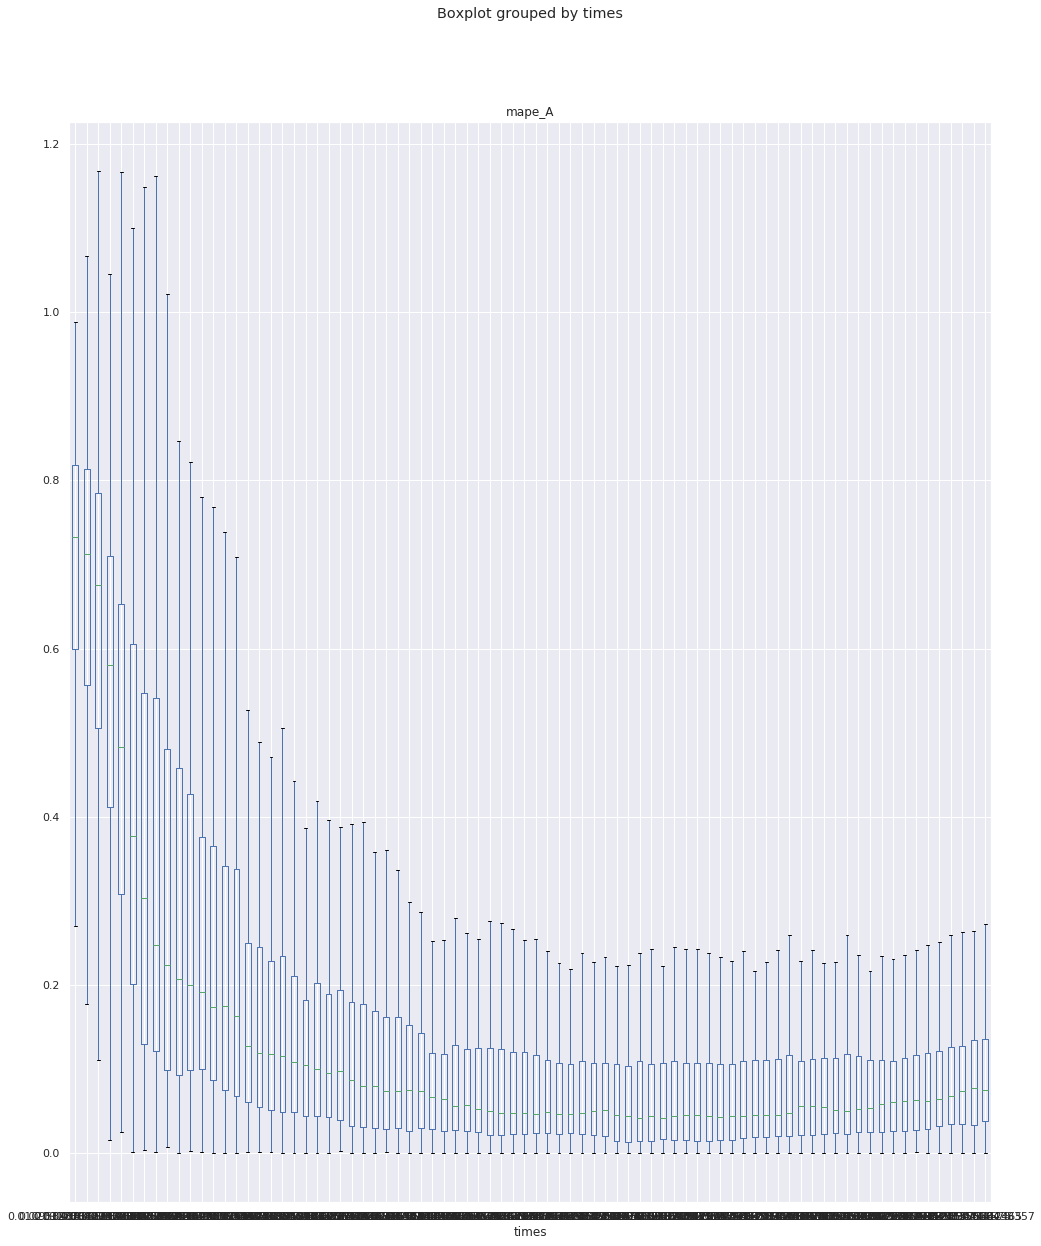

In [173]:
test_data.boxplot( "mape_A" , by="times",showfliers=False)


Isotope A is suposed to have a nice temporal behaviour, it should be quite easy to get good results with this kind of isotope on the whole period of time...

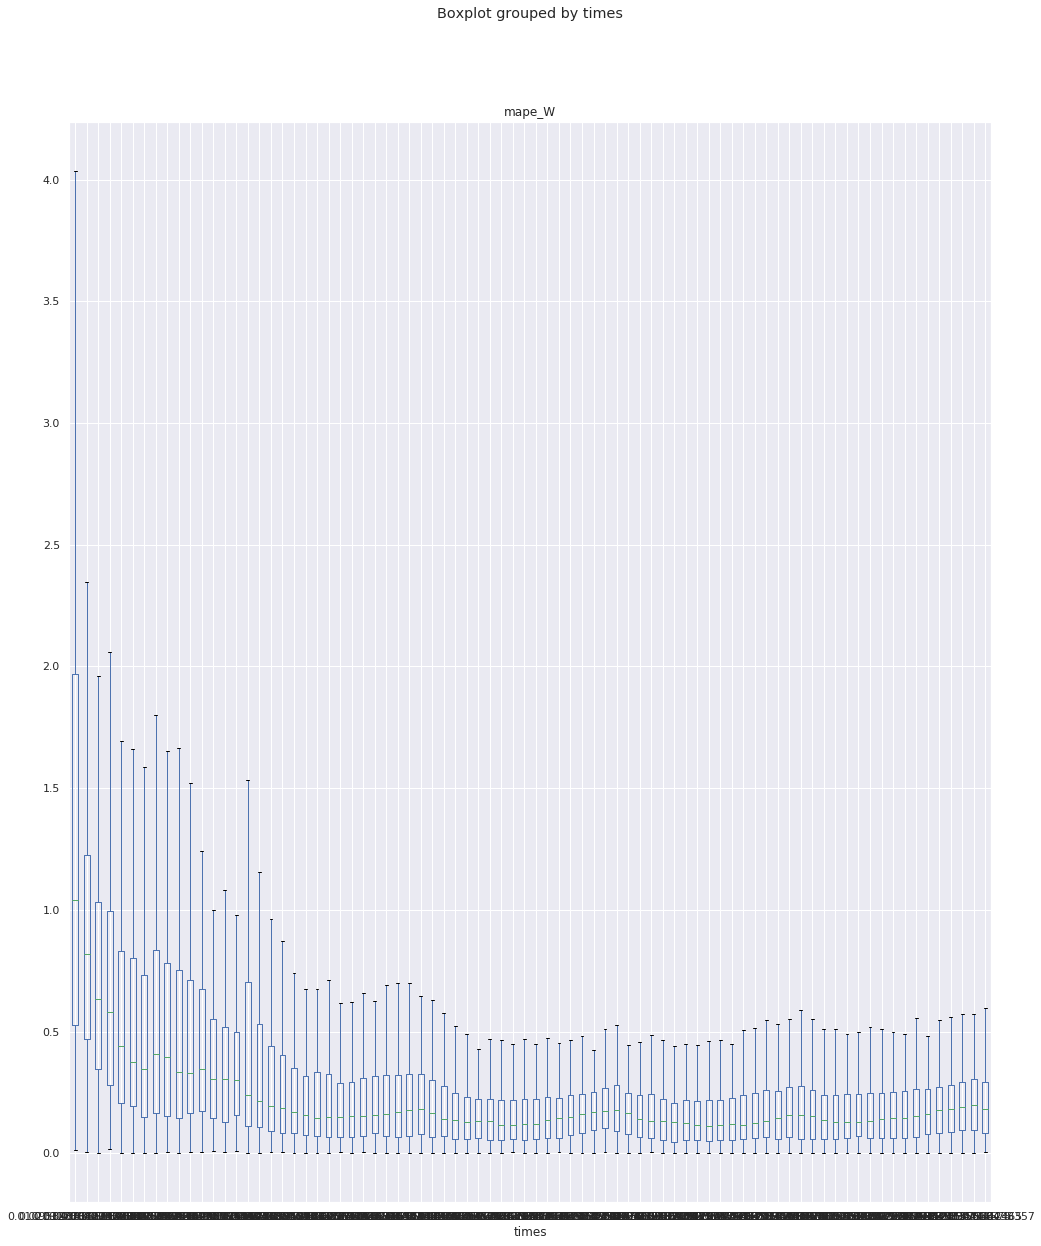

In [174]:
test_data.boxplot( "mape_W" , by="times",showfliers=False)

Let us look at the dirstibutions of the true and predicted compositions for the final time (T = 1825 days) 

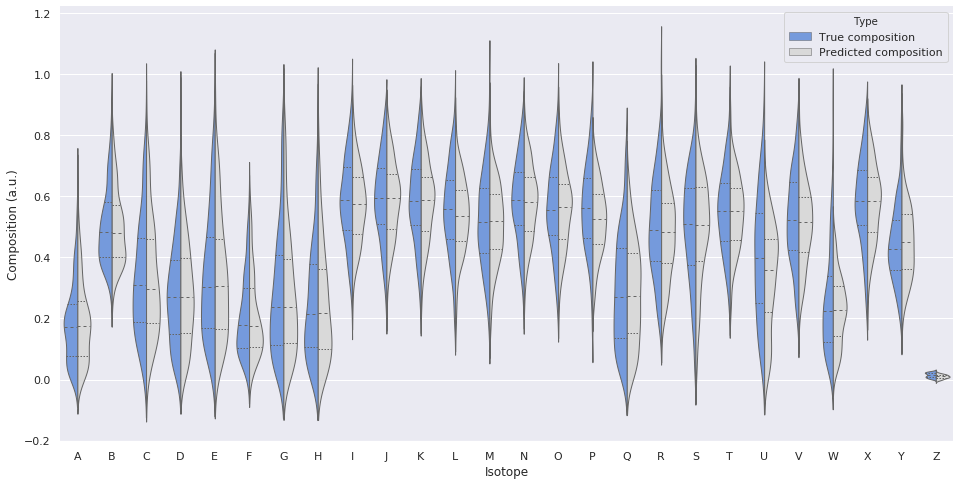

In [176]:
test_data_final = test_data[ test_data["times"]*max_train_data.times == 1825.0] 

d={}

d["Composition (a.u.)"] = []
d["Isotope"] = [ ]
d["Type"] = []


for i in alphabet: 
    
    
    d["Composition (a.u.)"] += test_data_final["Y_"+i].to_list() + test_data_final["res_"+i].to_list()
    d["Isotope"] += [i]*400
    d["Type"] += ["True composition"]*200 + ["Predicted composition"]*200

temp = pd.DataFrame(d)

sns.set(rc={'figure.figsize':(16,8)})
sns.violinplot(data=temp,x="Isotope",y="Composition (a.u.)",hue="Type",
               split=True, inner="quartile", linewidth=1
               , palette={"True composition":"cornflowerblue","Predicted composition":".85"})
sns.despine(left=True)

To conclude, let us highlight some discrepancies that we believe is typical from the hard cuts that were performed in the input parameter space :

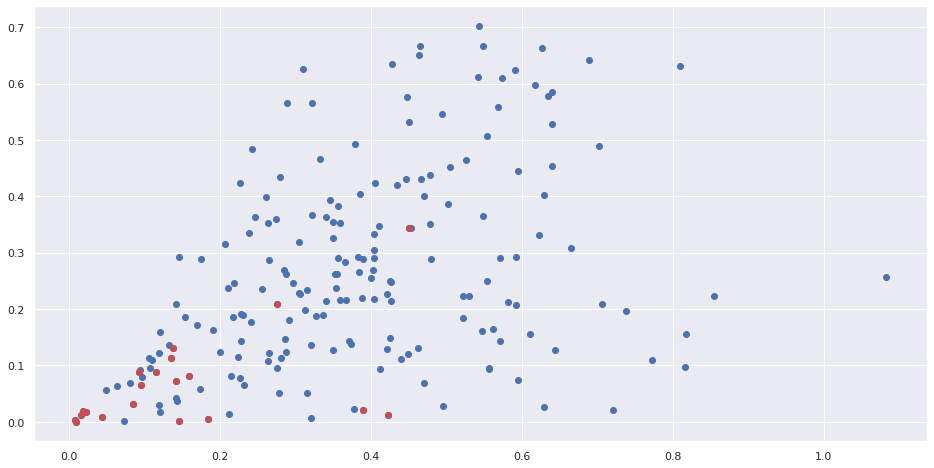

In [178]:
plt.plot( test_data_final["D"], test_data_final["H"], "bo")
plt.plot( test_data_final[np.fabs(test_data_final["mape_H"]) > 0.25]["D"], 
         test_data_final[np.fabs(test_data_final["mape_H"]) > 0.25]["H"], "ro")

plt.show()

The points in blue on the figure are the initial compositions of the test points in the input parameter space D vs H.

In red, the same test points are highlighted only if the error of the prediction at T=1825 days is greater than 25%. Most of the points with large errors are located in the corner of the distribution... 
